In [1]:
# !pip uninstall -y skforecast
# !pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [14]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

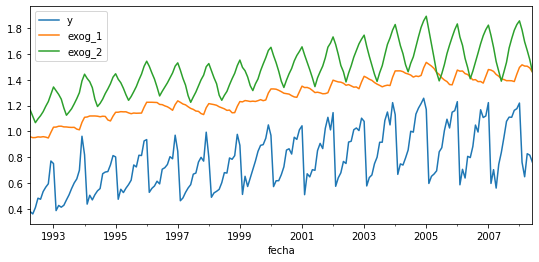

In [15]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoregMultiOutput without exogenous variables

In [18]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(data_train.y)
forecaster

<class 'skforecast.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput'> 
Regressor: LinearRegression() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False} 

Test error (mse): 0.01057883464790418


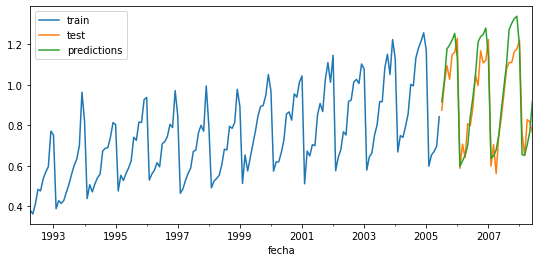

In [20]:
# Predict
# ==============================================================================
predictions = forecaster.predict()

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [23]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [10, 50],
              'max_depth': [5, 10]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    =  int(len(data)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(4)

root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:12<00:00,  4.18s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.030355,10,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.030453,5,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 10}",0.032194,10,10
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 10}",0.032301,5,10


In [30]:
# Predictors importance
# ==============================================================================
for step in range(forecaster.steps):
    print("Feature importance model step: ", step)
    print(forecaster.get_feature_importances(step=step+1))
    print("")

Feature importance model step:  0
[0.44787021 0.18727014 0.09712198 0.02763854 0.02500823 0.01858382
 0.02863839 0.02696394 0.04426784 0.0966369 ]

Feature importance model step:  1
[0.11613945 0.08238018 0.02699642 0.03368414 0.0134889  0.03854035
 0.02651885 0.05260933 0.09564028 0.51400211]

Feature importance model step:  2
[0.07554466 0.00999418 0.01840059 0.00855393 0.00785271 0.01343858
 0.02509001 0.04462543 0.02247804 0.77402187]

Feature importance model step:  3
[0.02579319 0.0358573  0.00678395 0.00998678 0.01458758 0.01868984
 0.04170123 0.0260111  0.81212692 0.00846211]

Feature importance model step:  4
[0.02770466 0.00768405 0.01103679 0.0142283  0.01706352 0.0322734
 0.02523396 0.80974959 0.00819184 0.0468339 ]

Feature importance model step:  5
[0.00736848 0.01481313 0.0156931  0.01733496 0.03808245 0.02068456
 0.80716764 0.00721893 0.05125253 0.02038422]

Feature importance model step:  6
[0.01508762 0.01603623 0.01769504 0.03146231 0.0183679  0.79853619
 0.00744728 

Number of observations used for training or as initial window: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
[0.04440362]


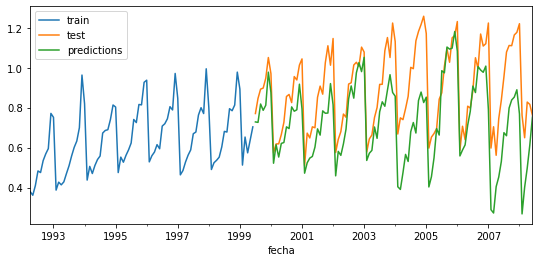

In [41]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]


forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
             )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    initial_train_size = len(data_train),
    steps      = forecaster.steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [42]:
predicciones_backtest

1999-07-01    0.728580
1999-08-01    0.726272
1999-09-01    0.818181
1999-10-01    0.786672
1999-11-01    0.812048
                ...   
2008-02-01    0.268439
2008-03-01    0.401580
2008-04-01    0.497775
2008-05-01    0.613154
2008-06-01    0.752837
Freq: MS, Name: pred, Length: 108, dtype: float64

In [43]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
np.allclose(predicciones_backtest, np.concatenate([predictions_1, predictions_2, predictions_3]))

True

# ForecasterAutoregMultiOutput with 1 exogenous variables

In [44]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [46]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train.y, exog=data_train.exog_1)
forecaster

<class 'skforecast.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput'> 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

Test error (mse): 0.00810760566140999


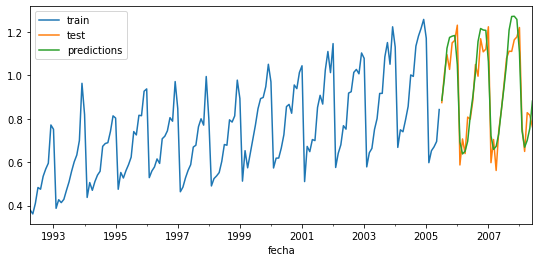

In [47]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [49]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 10
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

root       INFO  Number of models compared: 12
loop lags_grid:   0%|                                     | 0/3 [00:01<?, ?it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 8 and the array at index 1 has size 28

In [ ]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]
data_exog_train = data_exog[:-n_test]
data_exog_test  = data_exog[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 2,
                    lags      = 3
                )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data,
                            exog       = data_exog,
                            initial_train_size = len(data_train),
                            steps      = forecaster.steps,
                            metric     = 'mean_squared_error'
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predictions, index=data_test[:len(predictions)].index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Autoregressive + n exogenous predictors
<br>

In [ ]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

In [ ]:
# Feature importance
# ==============================================================================
for step in range(1, forecaster.steps):
    print(f"\n Model step: {step}")
    print(forecaster.get_feature_importances(step = step))

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(exog=data_test[['exog_1', 'exog_2']])


# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
data_train = data.iloc[:-n_test]
data_test  = data.iloc[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

metrica, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data['y'],
                            exog       = data[['exog_1', 'exog_2']],
                            initial_train_size = len(data_train),
                            steps      = forecaster.steps,
                            metric     = 'mean_squared_error'
                       )

print(metrica)


# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#data_train.plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Información de sesión

In [ ]:
from sinfo import sinfo
sinfo()